# This notebook will show the implementation of RangingNN for generating peaks ranges in a APT mass-to-charge spectrum

## Contents


- [Import modules](#Import-modules)
- [Load data and preprocessing](#training-data-precheck)
- [Load model and run inference](#train)
- [Visualization](#model-prediction-and-evaluation)
- [Blind validation: load .apt and export .RRNG](#Blind-validation:-load-.apt-and-export-.RRNG)


# Import modules

In [6]:
import apav
import os
import peak_detection
from peak_detection.RangingNN.predictor import DetectionPredictor
import numpy as np
import matplotlib.pyplot as plt
import torch
def normalize(spectrum, ranges):
    return (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min()), ranges / 307.2
print(np.__version__,torch.__version__)

# Load data and preprocessing

**! change the file path according to your file directory**

**If run on colab, upload files to google drive and mount your drive first**


In [2]:
apt_file = '/srv/home/jwei74/APT_ML/ranging/rawdata/R13_40310Zr Top Level ROI.apt' # change here
range_file = '/srv/home/jwei74/APT_ML/ranging/rawdata/ExaminedRanges/R13_40310Zr Top Level ROI.RRNG' # change here

#load the apt and get histogram
d = apav.load_apt(apt_file)
x, spectrum = d.mass_histogram(bin_width=0.01, lower=0, upper=307.2, multiplicity='all', norm=False, )

#load the rrng and labeled peaks
range_label = apav.RangeCollection.from_rrng(range_file)
peakl = np.array([r.lower for r in range_label.ranges])
peakh = np.array([r.upper for r in range_label.ranges])
peaks = np.vstack((peakl, peakh)).T

spectrum_log = np.log(spectrum+1)
spectrum_log, range_gt = normalize(spectrum_log, peaks)
spectrum_log = torch.tensor(spectrum_log, dtype=torch.float32) 

# Load model and run inference

In [ ]:
cfg = os.path.dirname(peak_detection.__file__) + '/RangingNN/cfg/prediction_args.yaml' # loading the default parameter file in the package
modelpath = os.path.join(os.path.dirname(peak_detection.__file__), 'RangingNN/modelweights', 'best.pt') # loading the default trained-model in the package
save_dir = './test' # auto save results not implemented yet

predictor = DetectionPredictor(modelpath, spectrum_log[None, None, ...], save_dir = save_dir, cfg = cfg)
result = predictor()[0]
peak_pred = result[:,:2].cpu()

# Visualization

In [9]:
# enabling interactive plot
try:
    import ipympl
except:
    !pip install ipympl
try:
    import google.colab
    from google.colab import output
    output.enable_custom_widget_manager()
    %matplotlib widget
except: # when not in google colab
    %matplotlib widget

labeled peaks: 33 ; model predicted peaks: 35


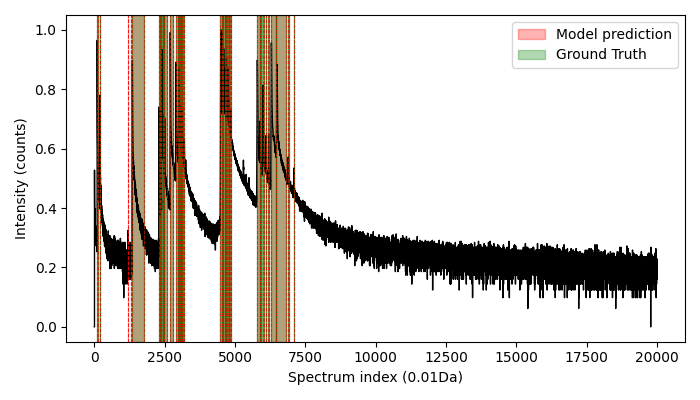

In [49]:
# set the zoom in m/c range
plot_max = 20000 # in 0.01 Da
plot_min = 0
bin_width = 0.01
peak_pred_ = peak_pred[(peak_pred[:,0] < plot_max) & (peak_pred[:,0] >plot_min)]

peaks_ = peaks / bin_width # scale the labels
peaks_ = peaks_[(peaks[:,0] < plot_max) & (peaks[:,0] >plot_min)]
print('labeled peaks:', peaks.shape[0],'; model predicted peaks:',peak_pred.shape[0] )

# Create the plot
fig, ax = plt.subplots(figsize=(7, 4))

# Plot the spectrum
x = 0.01 * torch.linspace(plot_min,plot_max, plot_max - plot_min)

ax.plot(x[...,None], spectrum_log[..., plot_min:plot_max].T, 'k-', linewidth=1)


# Add color boxes for each peak range
# Add vertical lines to show the boundaries of ranges

for start, end in peak_pred_:
    ax.axvspan(start*0.01, end*0.01, alpha=0.3, color='red',label='Model prediction' if start == peak_pred_[0][0] else "")
for start, end in peak_pred_:
    ax.axvline(start*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)
    ax.axvline(end*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)


for start, end in peaks_:
    ax.axvspan(start*0.01, end*0.01, alpha=0.3, color='green',label='Ground Truth'if start == peaks_[0][0] else "")
for start, end in peaks_:
    ax.axvline(start*0.01, color='green', linestyle=':', alpha=0.7, lw = 0.5)
    ax.axvline(end*0.01, color='green', linestyle=':', alpha=0.7, lw = 0.5)

# Set labels and title
ax.set_xlabel('Mass to charge ratio (Da)')
ax.set_ylabel('Intensity in log scale normalized(counts)')

# Adjust the plot layout
plt.tight_layout()
plt.legend()

# Blind validation: load .apt and export .RRNG

In [7]:
def map01(spectrum):
    return (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min())

In [98]:
apt_file = '/srv/home/jwei74/APT_ML/ranging/VALIDATION/R6025_272235.apt'
#apt_file = '/srv/home/jwei74/APT_ML/ranging/VALIDATION/UWPIDU.apt'
#apt_file = '/srv/home/jwei74/APT_ML/ranging/VALIDATION/UWPIDW.apt'

#load the apt and get histogram
d = apav.load_apt(apt_file)
x, spectrum = d.mass_histogram(bin_width=0.01, lower=0, upper=307.2, multiplicity='all', norm=False,)

spectrum_log = np.log(spectrum+1)
spectrum_log = map01(spectrum_log)
spectrum_log = torch.tensor(spectrum_log, dtype=torch.float32) 

In [101]:
save_dir = './test'
cfg = os.path.dirname(peak_detection.__file__) + '/RangingNN/cfg/prediction_args.yaml' # loading the default parameter file in the package
modelpath = os.path.join(os.path.dirname(peak_detection.__file__), 'RangingNN/modelweights', 'best.pt') # loading the default trained-model in the package

predictor = DetectionPredictor(modelpath, spectrum_log[None, None, ...], save_dir = save_dir, cfg = cfg)
result = predictor()[0]
peak_pred = result[:,:2].cpu()
print('model predicted peaks:',peak_pred.shape[0])


Start inference
Speed:  45.3ms inference, 10.1ms postprocess for per spectrum 
model predicted peaks: 120


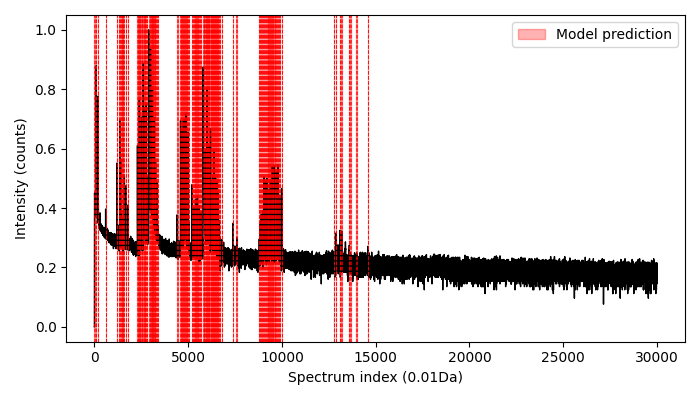

In [102]:
# set the zoom in m/c range
plot_max = 30000 # in 0.01 Da
plot_min = 0
bin_width = 0.01
peak_pred_ = peak_pred[(peak_pred[:,0] < plot_max) & (peak_pred[:,0] >plot_min)]


# Create the plot
fig, ax = plt.subplots(figsize=(7, 4))

# Plot the spectrum
x = 0.01 * torch.linspace(plot_min,plot_max, plot_max - plot_min)

ax.plot(x[...,None], spectrum_log[..., plot_min:plot_max].T, 'k-', linewidth=1)


# Add color boxes for each peak range
# Add vertical lines to show the boundaries of ranges

for start, end in peak_pred_:
    ax.axvspan(start*0.01, end*0.01, alpha=0.3, color='red',label='Model prediction' if start == peak_pred_[0][0] else "")
for start, end in peak_pred_:
    ax.axvline(start*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)
    ax.axvline(end*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)

# Set labels and title
ax.set_xlabel('Mass to charge ratio (Da)')
ax.set_ylabel('Intensity in log scale normalized(counts)')
# Adjust the plot layout
plt.tight_layout()
plt.legend()

In [96]:
rng_col = apav.RangeCollection()
bin_width = 0.01
for p in peak_pred:
    p[p<0]=0
    rng_col.add(apav.Range("X", (float(p[0]*bin_width), float(p[1]*bin_width))))

In [97]:
# export the ranges to RRNG file
rng_col.to_rrng('/srv/home/jwei74/APT_ML/ranging/VALIDATION/R6025_272235_RangingNN.RRNG')
#rng_col.to_rrng('/srv/home/jwei74/APT_ML/ranging/VALIDATION/UWPIDU_RangingNN.RRNG')
#rng_col.to_rrng('/srv/home/jwei74/APT_ML/ranging/VALIDATION/UWPIDW_RangingNN.RRNG')
